Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$

where $c$ stands for the various physics channels that contribute to the final state $x$, $\mu$ is the signal-strength parameter and $\alpha$ is the vector of nuisance parameters associated with the various systematic uncertainties in the model. Note that we are assuming that the parameter $\mu$-dependence is known analytically and that we have simulation models for each of the channels $p_c(x)$. 

The objective is to build the test statistic for composite hypothesis testing:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\alpha}})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\alpha})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\alpha}})}{p(x_i|\hat{\mu}, \hat{\alpha})} + \sum_m^{N_\text{systs}} \alpha_m^2$$

A direct approach would then be to model the probability density $p(x|\mu, \alpha)$ using NNs. But that is a more difficult task than training probability density ratios. We use a simple trick:

$$t_\mu = -2 \cdot \frac{\text{Pois}(\mathcal{N}_\text{evts}|\mu, \hat{\hat{\alpha}})}{\text{Pois}(\mathcal{N}_\text{evts}|\hat{\mu}, \hat{\alpha})} -2 \cdot \sum_i^{\mathcal{N}_\text{evts}} w_i \times \log \frac{p(x_i|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x_i|\hat{\mu}, \hat{\alpha})/p_{ref}(x)} + \sum_m^{N_\text{systs}} \alpha_m^2$$


to turn this into a density ratio estimation problem:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot \frac{p_c\left(x|\alpha\right)}{p_{ref}(x)}$$

Factorizing out the $\alpha$-dependence in the density ratios:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha)\cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

**Factorized approach:**

Instead of training NNs parameterized on $\mu$ and $\alpha$, we use analytical parameterizations to simplify the problem to training only parameter-independent density ratios.

Let's set this up for the toy ttbar model we are using. Neglecting the nuisance parameter dependence for now, 

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}\right] = \mu \cdot \frac{p_{H \to \tau\tau}\left(x\right)}{p_{ref}(x)} + \frac{p_{t\bar{t}}\left(x\right)}{p_{ref}(x)} + \frac{p_{H \to \tau\tau}\left(x\right)}{p_{ref}(x)}$$

In [1]:
import os, sys, importlib
sys.path.append('../')

import nsbi_common_utils
from nsbi_common_utils import plotting, training
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle

from utils import preselection_using_score, calculate_preselection_observable

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/src/nsbi_common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-06-04 21:56:08.728737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749074168.741782  482920 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749074168.745662  482920 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 21:56:08.760595: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instr

In [ ]:
path_prefix = '/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/'

# Path for saving interemdiate objects, like NN predictions
saved_data = f'{path_prefix}cached_data/'

# Path for saving/loading preselection NN model
path_to_saved_presel_model = f'{path_prefix}preselection_saved_NN/'

# Load the nominal dataset saved from the pre-processing notebook
dataset_incl_nominal = pd.read_hdf(f"{saved_data}df_nominal.h5", key="dataset", mode='r')

In [2]:
# If the preselection NN has already been trained and saved, load from the saved model
USE_SAVED_MODEL_PRESEL=True
# If the preselection NN has already been trained and evaluated, load the numpy array of predictions
USE_SAVED_PRESEL_PREDICTIONS=True

# Get the dictionary of labels to processes
labels_dict = np.load(f"{saved_data}labels_dictionary.npy", allow_pickle=True).item()

# Features to use for training NNs
columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']
columns_scaling = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi']

# columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt', 'PRI_n_jets', 'has_jets']
# columns_scaling = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt']

# columns = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'has_jets']
# columns_scaling = ['PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_jet_all_pt', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta']


np.save(f"{saved_data}columns.npy", columns)
np.save(f"{saved_data}columns_scaling.npy", columns_scaling)


signal_processes = ["htautau"]
background_processes = ["ttbar", "ztautau"]
# background_processes = ["ttbar", "ztautau", "diboson"]

# mix_model_hypotheses = signal_processes + background_processes
mix_model_hypotheses = background_processes
ref_processes = signal_processes

np.save(f"{saved_data}mix_model_hypotheses.npy", mix_model_hypotheses)
np.save(f"{saved_data}ref_processes.npy", ref_processes)

pre_factor_preselection_score = {}

pre_factor_preselection_score['htautau'] = 1.0
pre_factor_preselection_score['ttbar'] = 1.0
pre_factor_preselection_score['ztautau'] = 1.0

np.save(f"{saved_data}signal_processes.npy", signal_processes)
np.save(f"{saved_data}background_processes.npy", background_processes)
np.save(f"{saved_data}pre_factor_preselection.npy", pre_factor_preselection_score)


In [3]:

# Load the MC/data weights and training labels identifying different processes
weights = dataset_incl_nominal.weights.to_numpy()
train_labels = dataset_incl_nominal.train_labels.to_numpy()

In [5]:
# Normalizing the training weights - only discriminating shapes, not norms
weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset_incl_nominal['weights_normed'] = weights_normed


Training the Preselection NN
===

**Choice of reference sample**

The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, or $p_c(x) \gg p_{ref}(x)$, and only perform the NSBI fit in this selected analysis region. **A natural choice for the reference hypothesis is then the signal-rich hypotheses**. This is referred to in the ATLAS publications as the Search-Oriented Mixture Models approach: 

$$p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx} = \frac{1}{\nu_{H \to \tau\tau}} \frac{d\sigma_{H \to \tau\tau}}{dx}$$

where the sum runs over all signal hypothesis in the model and the second equality is due to the sole signal hypothesis in our toy model, $pp \to {t\bar{t}}$. 

**Selecting out regions with $p_{ref}\sim 0$**

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_c$ are the probability scores outputted from the softmax layer of the trained NN.



In [10]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluatePreselNN

num_classes = len(labels_dict)

preselectionTraining = TrainEvaluatePreselNN(dataset_incl_nominal, num_classes, columns, columns_scaling)

In [11]:
if USE_SAVED_PRESEL_PREDICTIONS:
    presel_score = np.load(f"{saved_data}presel_score.npy")


else:
    if not USE_SAVED_MODEL_PRESEL:
        preselectionTraining.train(test_size=0.2, 
                                   random_state=4242, 
                                   path_to_save=path_to_saved_presel_model,
                                  batch_size=4096,
                                  epochs=50, learning_rate=0.1)
    
    else:
        preselectionTraining.get_trained_model(path_to_saved_presel_model)

    # Get predictions (softmax outputs)
    pred_NN_incl = preselectionTraining.predict(dataset_incl_nominal)

    presel_score = calculate_preselection_observable(pred_NN_incl, labels_dict, signal_processes, background_processes, pre_factor_dict = pre_factor_preselection_score)

    np.save(f"{saved_data}presel_score.npy", presel_score)
    np.save(f"{saved_data}pred_NN_incl.npy", presel_score)

    

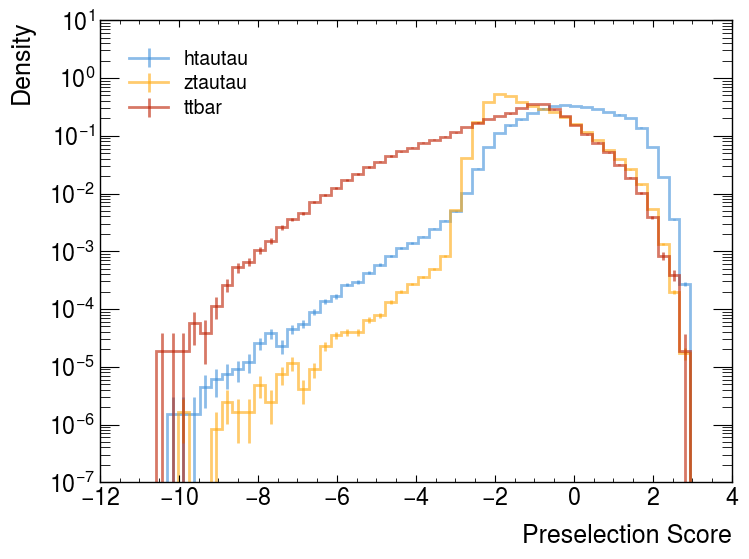

In [13]:
min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=50)

hist_NN_output = {}
hist_NN_output_errs = {}

for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], 
                                          weights = weights[train_labels==labels_dict[key]], bins=bins)
    
    hist_NN_output_errs[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], 
                                          weights = weights[train_labels==labels_dict[key]]**2, bins=bins)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0, yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Making the cut
===

Make a selection cut for regions with $p_{ref} \gg 0$ for performing the NSBI analysis. The remaining events - which by definition are background-dominated - can be used as a **Control Region** for data-driven background estimation, pre-unblinding validations, etc. 

Moreover, the preselections act as a tuning know for the tradeoff in selecting as many signal events as possible to go into the **Signal Region** (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics). **The preselections can also weed out phase space regions with low background statistics to avoid poorly modelled regions.** 

Heres a first cut that you can optimize as much as you like to get the desired final results. 

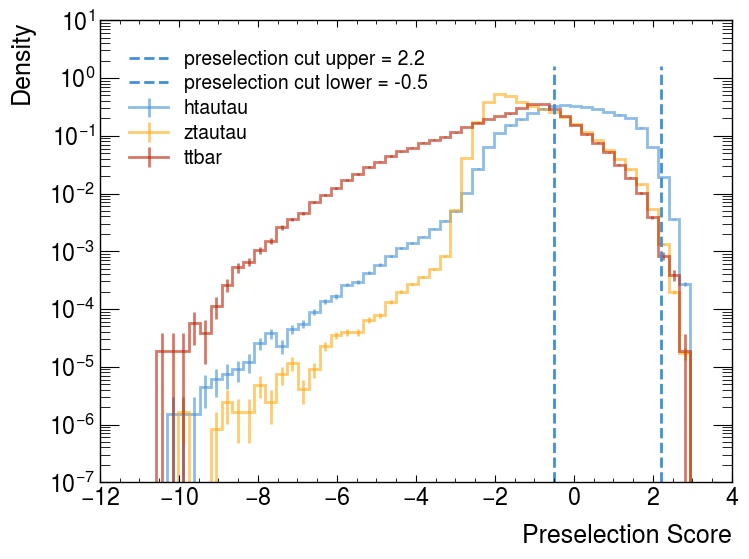

In [14]:
# Play around with these selections - decrease if estimators are unbiased but need more sensitivity and increase if the model is biased to reduce complexity
preselection_cuts = {'upper': 2.2, 'lower': -0.5}
np.save(f"{saved_data}preselection_cuts.npy", preselection_cuts)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins = bins, 
             alpha = 0.6, label = key, 
             density = True, linewidth = 2.0, 
                 yerr = np.sqrt(hist_NN_output_errs[key]))

plt.xlabel("Preselection Score", size=18)

for key in preselection_cuts:
    if preselection_cuts[key] != -999:
        plt.axvline(preselection_cuts[key], ymax=0.9, linestyle='--', label=f'preselection cut {key} = {preselection_cuts[key]}')

plt.ylabel("Density", size=18)
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

Signal and Control Regions
===

The high signal over background phase space towards the right of the preselection cut shown above will be categorized as the **Signal Region** where the NSBI analysis is performed.

The low signal phase space towards the left will be used as a **Control Region**, with typical uses such as background estimation, pre-unblinding data-MC checks, etc. In this phase space, we will use a binned summary observable like in any traditional analysis.

In [15]:
dataset_incl_nominal['presel_score'] = presel_score

dataset, dataset_CR = preselection_using_score(dataset_incl_nominal, preselection_cuts)

del dataset_incl_nominal

In [16]:
# Build a summary observable for Control Region
hist_CR = {}
num_bins = 10

CR_observable='PRI_had_pt'
np.save(f"{saved_data}observable_CR.npy", CR_observable)

kin_variable = dataset_CR[CR_observable].to_numpy()

min_kin = np.amin(kin_variable)
max_kin = np.amax(kin_variable)
min_kin = 30.0
max_kin = 80.0

bins = np.linspace(min_kin, max_kin, num=num_bins)

# Use the high-level preselection NN score as a summary observable for Control Region
for channel_ in labels_dict:
    dataset_CR_process = dataset_CR[dataset_CR.detailed_labels==channel_]
    hist_CR[channel_], bins = np.histogram(np.clip(dataset_CR_process[CR_observable].ravel(), min_kin, max_kin),
                                  weights = dataset_CR_process['weights'].ravel(),
                                  bins = bins)

# Save the Control Region observable
with open(f"{saved_data}hist_CR_ttbar.pkl", "wb") as fp:
    pickle.dump(hist_CR, fp)

np.save(f"{saved_data}CRbins.npy", bins)

# del dataset_CR

Text(0, 1, 'Density')

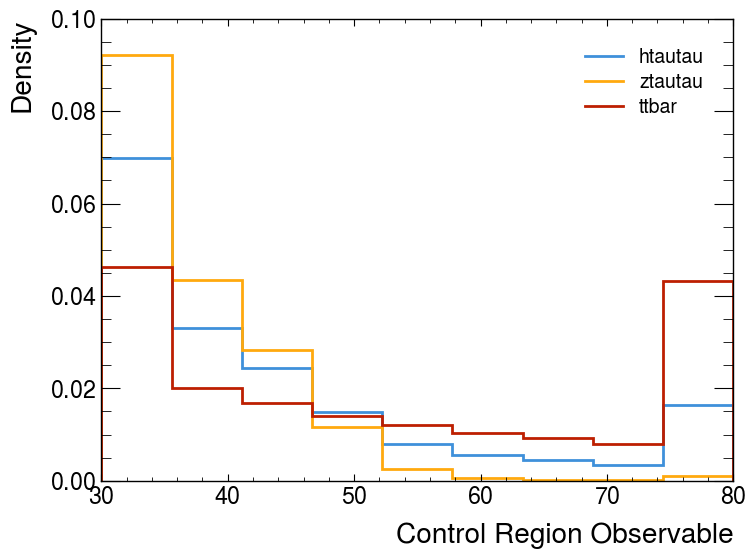

In [17]:
# Plot the Control Region observable

for channel_ in labels_dict:
    hep.histplot(hist_CR[channel_], bins=bins, label=channel_, density=1, linewidth=2.0)

plt.legend()
plt.xlabel('Control Region Observable')
# plt.yscale('log')
plt.ylabel('Density')

In [18]:
# Save the preselected Nominal dataframe for inference use later on
dataset.to_hdf(f"{saved_data}dataset_preselected_nominal_SR.h5", key="dataset", mode='w')


In [19]:
top_path = f'{path_prefix}output_training_nominal/'

Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Our choice of reference hypothesis, motivated by the search-oriented mixture model described above, is: 

$$p_{ref}(x) = p_\text{higgs}(x) = \frac{1}{\nu_{H \to \tau\tau}} \frac{d\sigma_{H \to \tau\tau}}{dx} $$

gives the POI $\mu-$parameterized model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu + \frac{p_{t\bar{t}}\left(x\right)}{p_{H \to \tau\tau}(x)} + \frac{p_{Z \to \tau\tau}\left(x\right)}{p_{H \to \tau\tau}(x)}$$

The task of estimating the $\mu-$parameterized density ratio is thus reduced to estimating two $\mu-$independent density ratios $\frac{p_\text{single top}}{p_{t\bar{t}}}(x)$ and $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$ mixed together with an analytical parameterization (hence the name mixture model).

In [21]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

mask_ref = np.isin(dataset.detailed_labels, ref_processes)

NN_training_mix_model = {}

rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now

for process_type in mix_model_hypotheses:
    
    mask_process = dataset['type']==process_type
    
    dataset_num = dataset[mask_process].copy()
    dataset_ref = dataset[mask_ref].copy()

    dataset_num['train_labels'] = 1
    dataset_ref['train_labels'] = 0

    dataset_num['weights_normed'] = dataset_num['weights'].to_numpy() / dataset_num['weights'].sum()
    dataset_ref['weights_normed'] = dataset_ref['weights'].to_numpy() / dataset_ref['weights'].sum()

    # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
    dataset_mix_model = pd.concat([dataset_num, dataset_ref])

    del dataset_num, dataset_ref

    # Save paths
    output_name = f'{process_type}'
    output_dir = f'{top_path}general_output_{process_type}'
    path_to_ratios = f'{top_path}output_ratios_{process_type}/'
    path_to_figures = f'{top_path}output_figures_{process_type}/'
    path_to_models = f'{top_path}output_model_params_{process_type}/'

    NN_training_mix_model[process_type] = TrainEvaluate_NN(dataset_mix_model, 
                                                           dataset_mix_model['weights_normed'],
                                                           dataset_mix_model['train_labels'],
                                                           columns, 
                                                           columns_scaling, rnd_seed_traintestsplit,
                                                           [process_type, 'ref'], output_dir, output_name, 
                                                            path_to_figures=path_to_figures,
                                                            path_to_ratios=path_to_ratios, 
                                                            path_to_models=path_to_models)


    del dataset_mix_model


Neural Network architecture
===

Here we will start with a multi-layer perceptron (simple feed-forward Neural Network with fully-connected layers). This can be supplemented with more complex architectures like transformers. 

After detailed tuning during the off-shell Higgs boson analysis effort, we found that a network with very wide layers ($\geq 1000$) and a depth of less than 10 works best - alongside batch size of a few hundreds and a gradually declining learning rate that starts with a value just large enough to not blow up.

Starting with the training and validation of the various density ratio:

$$\frac{p_{t\bar{t}}(x)}{p_\text{ref}(x)}, \frac{p_{Z \to \tau\tau}(x)}{p_\text{ref}(x)}$$

In [22]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [23]:
mix_model_hypotheses

['ttbar', 'ztautau']

In [24]:
# Define unique settings for each process type

training_settings = {
    'ttbar': {
        'hidden_layers':        2,
        'neurons':              1000,
        'number_of_epochs':     100,
        'batch_size':           512,
        'learning_rate':        0.1,
        'scalerType':           'StandardScaler',
        'calibration':          True,
        'num_bins_cal':         100,
        'callback':             True,
        'callback_patience':    30,
        'callback_factor':      0.01,
        'verbose':              2
    },
    
    'ztautau': {
        'hidden_layers':        2,
        'neurons':              1000,
        'number_of_epochs':     100,
        'batch_size':           512,
        'learning_rate':        1.0,
        'scalerType':           'StandardScaler',
        'calibration':          True,
        'num_bins_cal':         100,
        'callback':             True,
        'callback_patience':    30,
        'callback_factor':      0.01,
        'verbose':              2
    }
}

Sum of weights of class 0: 0.6999995708465576
Sum of weights of class 1: 0.700005292892456
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749074181.559737  482920 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1922 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:c1:00.0, compute capability: 8.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1000)           │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,001 (3.85 MB)

 Trainable params: 1,010,001 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100


I0000 00:00:1749074183.038361  484913 service.cc:148] XLA service 0x7f6284008a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749074183.038393  484913 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-06-04 21:56:23.082141: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749074183.165633  484913 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-06-04 21:56:23.552198: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 16 bytes spill stores, 20 bytes spill loads

I0000 00:00:1749074183.557253  484913 d

1945/1945 - 7s - 3ms/step - binary_accuracy: 0.6719 - loss: 7.8185e-07 - val_binary_accuracy: 0.6725 - val_loss: 7.7132e-07 - learning_rate: 0.1000
Epoch 2/100
1945/1945 - 4s - 2ms/step - binary_accuracy: 0.6881 - loss: 7.6003e-07 - val_binary_accuracy: 0.6874 - val_loss: 7.5027e-07 - learning_rate: 0.1000
Epoch 3/100
1945/1945 - 4s - 2ms/step - binary_accuracy: 0.6933 - loss: 7.5317e-07 - val_binary_accuracy: 0.6882 - val_loss: 7.4887e-07 - learning_rate: 0.1000
Epoch 4/100
1945/1945 - 4s - 2ms/step - binary_accuracy: 0.6936 - loss: 7.5037e-07 - val_binary_accuracy: 0.6890 - val_loss: 7.4868e-07 - learning_rate: 0.1000
Epoch 5/100
1945/1945 - 4s - 2ms/step - binary_accuracy: 0.6950 - loss: 7.4833e-07 - val_binary_accuracy: 0.6876 - val_loss: 7.5234e-07 - learning_rate: 0.1000
Epoch 6/100
1945/1945 - 4s - 2ms/step - binary_accuracy: 0.6954 - loss: 7.4558e-07 - val_binary_accuracy: 0.6909 - val_loss: 7.4403e-07 - learning_rate: 0.1000
Epoch 7/100
1945/1945 - 4s - 2ms/step - binary_accur

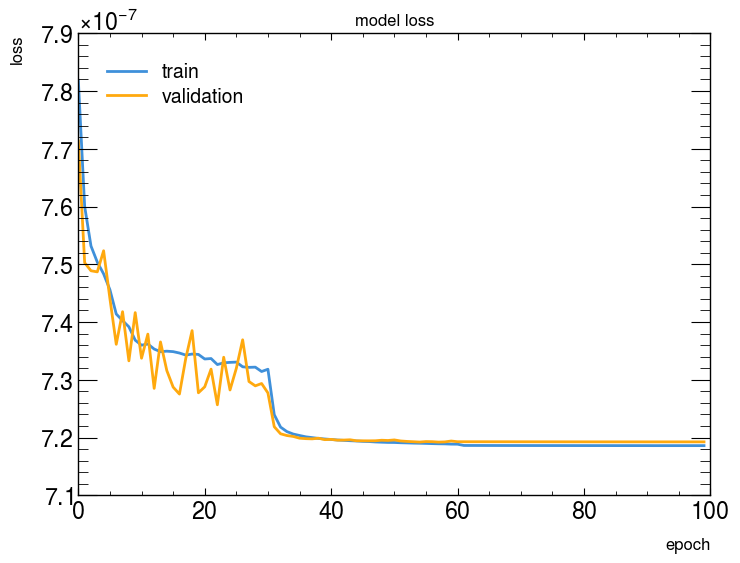

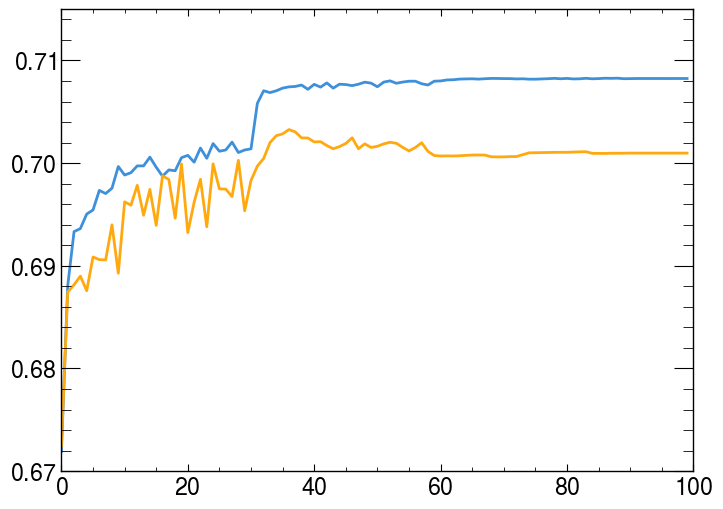

34567/34567 - 36s - 1ms/step
0.016815137
0.97287965
34567/34567 - 38s - 1ms/step
14814/14814 - 14s - 958us/step
49381/49381 - 41s - 839us/step
The sum of PDFs is 0.9998212456703186
Sum of weights of class 0: 0.6999996304512024
Sum of weights of class 1: 0.700001060962677
Using swish activation function


/home/jaySandesara/.conda/envs/NSBI/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1000)           │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1000)           │     1,001,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         1,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,001 (3.85 MB)

 Trainable params: 1,010,001 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

Using Callbacks
Epoch 1/100


2025-06-04 22:06:51.487192: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 8 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 16 bytes spill stores, 20 bytes spill loads



3146/3146 - 8s - 3ms/step - binary_accuracy: 0.6779 - loss: 4.8010e-07 - val_binary_accuracy: 0.6808 - val_loss: 4.7728e-07 - learning_rate: 1.0000
Epoch 2/100
3146/3146 - 6s - 2ms/step - binary_accuracy: 0.6826 - loss: 4.7523e-07 - val_binary_accuracy: 0.6809 - val_loss: 4.7689e-07 - learning_rate: 1.0000
Epoch 3/100
3146/3146 - 6s - 2ms/step - binary_accuracy: 0.6832 - loss: 4.7413e-07 - val_binary_accuracy: 0.6819 - val_loss: 4.7467e-07 - learning_rate: 1.0000
Epoch 4/100
3146/3146 - 6s - 2ms/step - binary_accuracy: 0.6837 - loss: 4.7337e-07 - val_binary_accuracy: 0.6794 - val_loss: 4.7703e-07 - learning_rate: 1.0000
Epoch 5/100
3146/3146 - 6s - 2ms/step - binary_accuracy: 0.6838 - loss: 4.7308e-07 - val_binary_accuracy: 0.6798 - val_loss: 4.7701e-07 - learning_rate: 1.0000
Epoch 6/100
3146/3146 - 6s - 2ms/step - binary_accuracy: 0.6842 - loss: 4.7286e-07 - val_binary_accuracy: 0.6820 - val_loss: 4.7509e-07 - learning_rate: 1.0000
Epoch 7/100
3146/3146 - 6s - 2ms/step - binary_accur

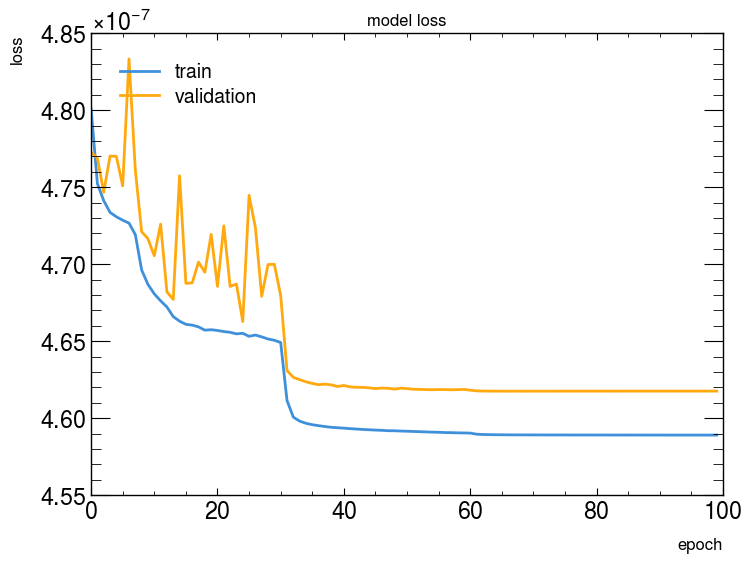

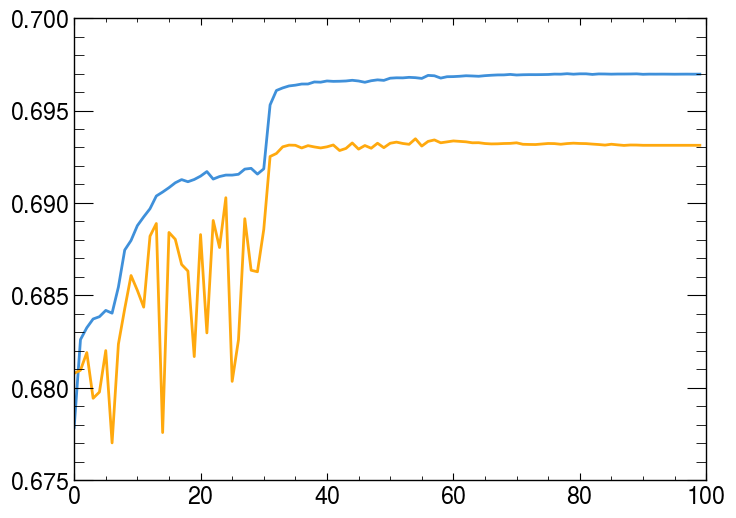

55914/55914 - 59s - 1ms/step
0.00089490006
0.99006265
55914/55914 - 62s - 1ms/step
23963/23963 - 27s - 1ms/step
79877/79877 - 63s - 787us/step
The sum of PDFs is 0.9995036721229553


<Figure size 800x600 with 0 Axes>

In [25]:
# Train the density ratio NN
for process_type in mix_model_hypotheses:
    
    settings = training_settings[process_type]

    NN_training_mix_model[process_type].train(**settings)
    NN_training_mix_model[process_type].test_normalization()



Check for overtraining by comparing the NN output distributions between training and holdout datasets. The holdout dataset is the subset of events not used during training.

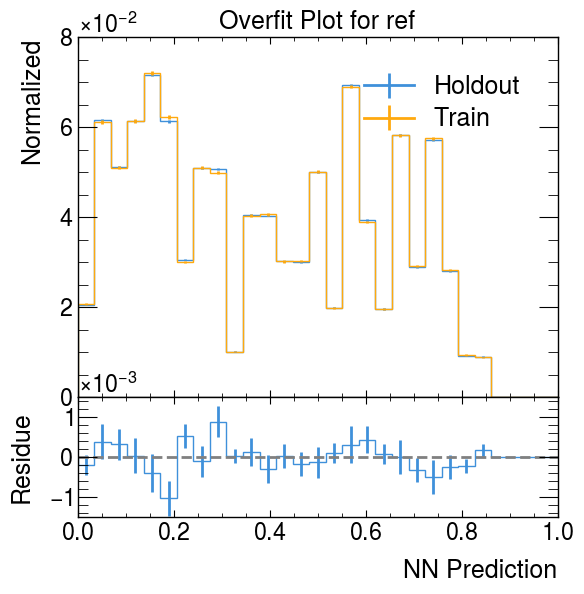

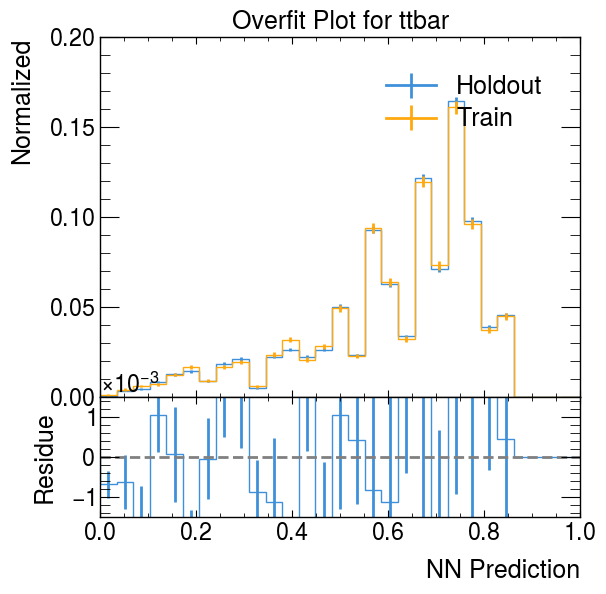

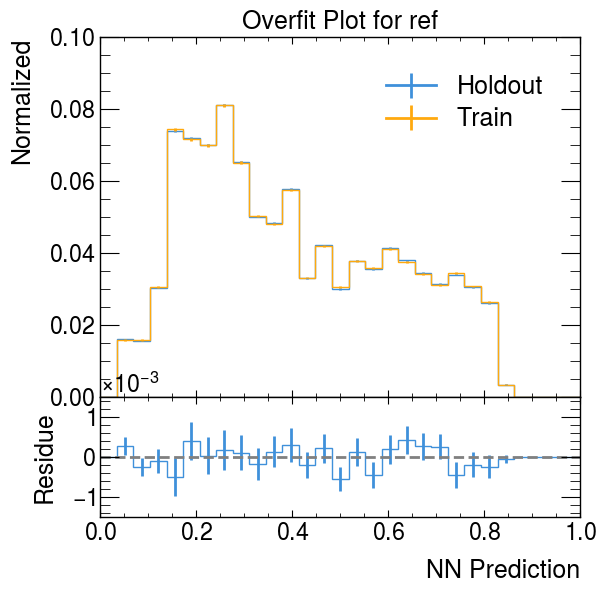

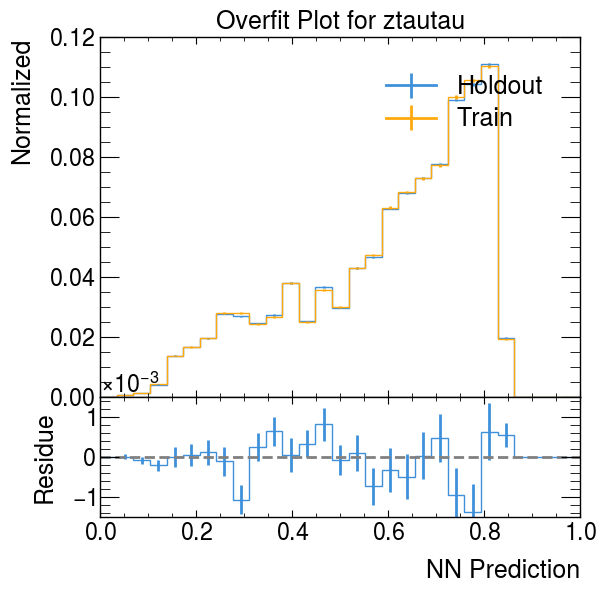

<Figure size 800x600 with 0 Axes>

In [26]:
for process_type in mix_model_hypotheses:
    NN_training_mix_model[process_type].make_overfit_plots()

Diagnostic Checks
===

While traditionally, a NN observable is judged on the basis of its accuracy - for NSBI we are interested in the quality of the density ratios more than the discrimination power. The latter comes from the perfect modelling of the multi-dimensional likelihood ratios.

To ensure correct modelling, we run two main checks on the training:

- **Calibration closure test**

  The NNs are trained using the binary cross-entropy loss, which under ideal conditions leads to the NN converging to the score function:

  $$\hat{s}_\text{pred} = \frac{p_\text{ref}(x)}{p_\text{ref}(x)+p_\text{c}(x)}$$

  that can be converted into the probability ratio we desire (likelihood ratio trick):

  $$\frac{p_\text{c}(x)}{p_\text{ref}(x)} = \frac{\hat{s}_\text{pred}(x)}{1-\hat{s}_\text{pred}(x)}$$

  For the NNs to be well-calibrated, we use the Monte Carlo samples to verify the equality:


  $$\left[\frac{p_c(x)}{p_c(x)+p_{ref}(x)}\right]_\text{NN} \sim \left[\frac{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}}{\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}+\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}}\right]_\text{MC}$$

  where we bin the events from $p_c$ and $p_\text{ref}$ MC samples, denoted by $\mathcal{N}_c^{I(x|\hat{s}_\text{pred})}$ and $\mathcal{N}_\text{ref}^{I(x|\hat{s}_\text{pred})}$ respectively where $I(x|\hat{s}_\text{pred})$ returns the index of the $\hat{s}_\text{pred}$ bin in which an event $x$ falls.
 


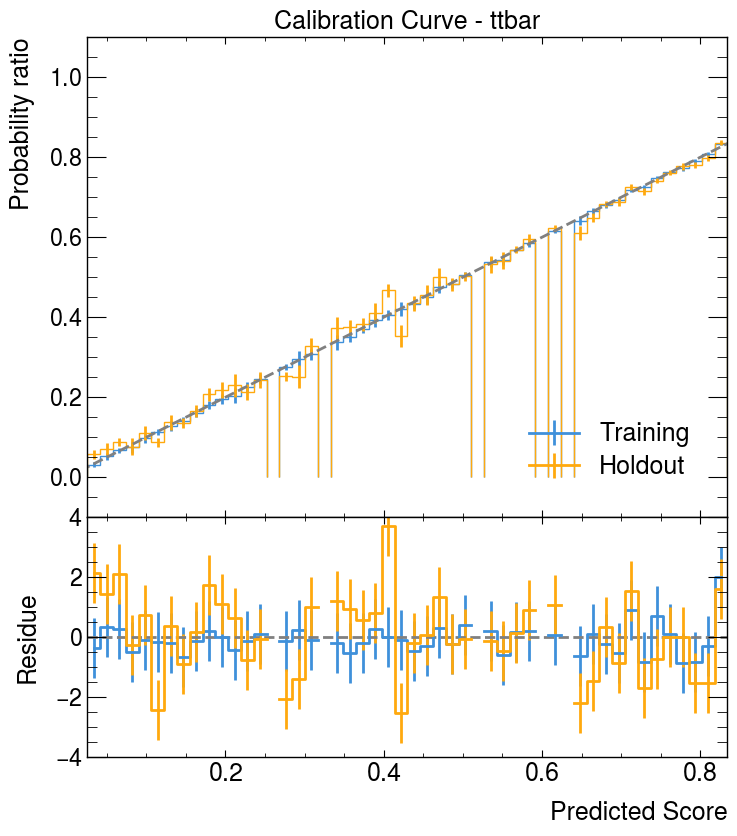

observable not recognized


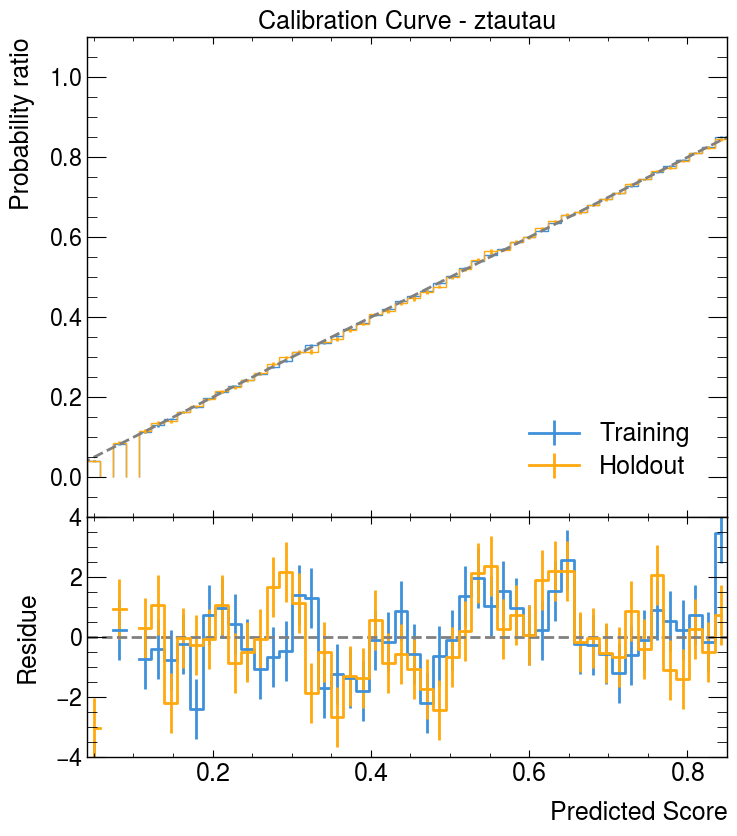

observable not recognized


<Figure size 800x600 with 0 Axes>

In [27]:
num_bins_cal = 50

for process_type in mix_model_hypotheses:
    NN_training_mix_model[process_type].make_calib_plots(nbins=num_bins_cal, observable='score')

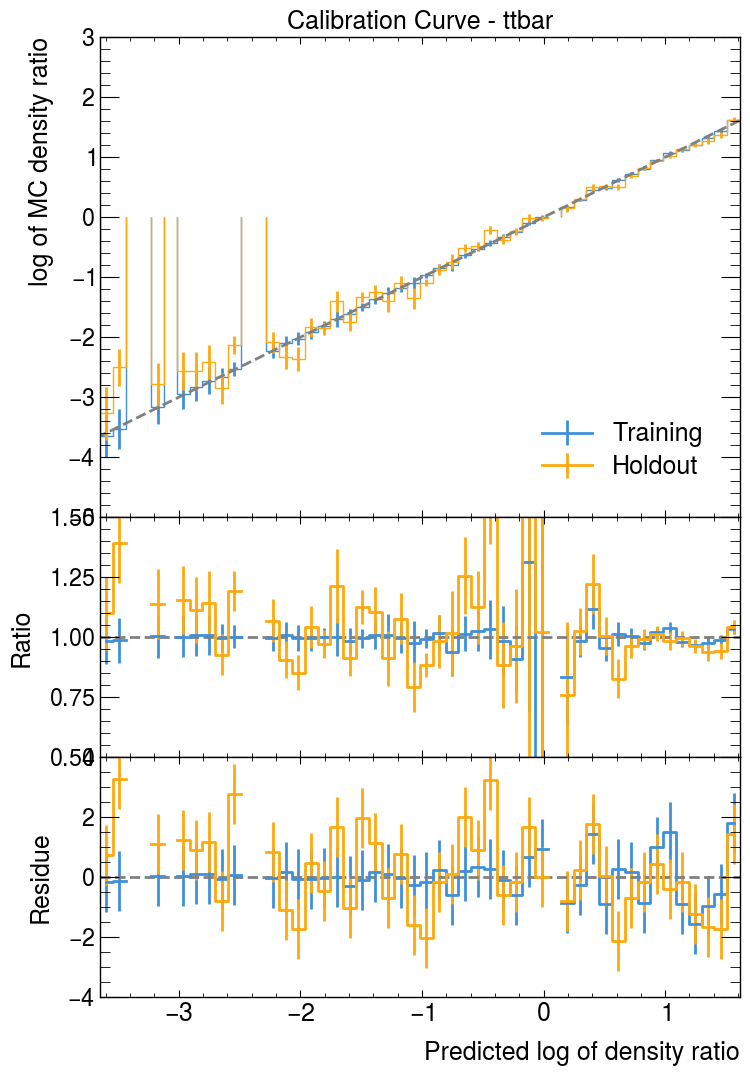

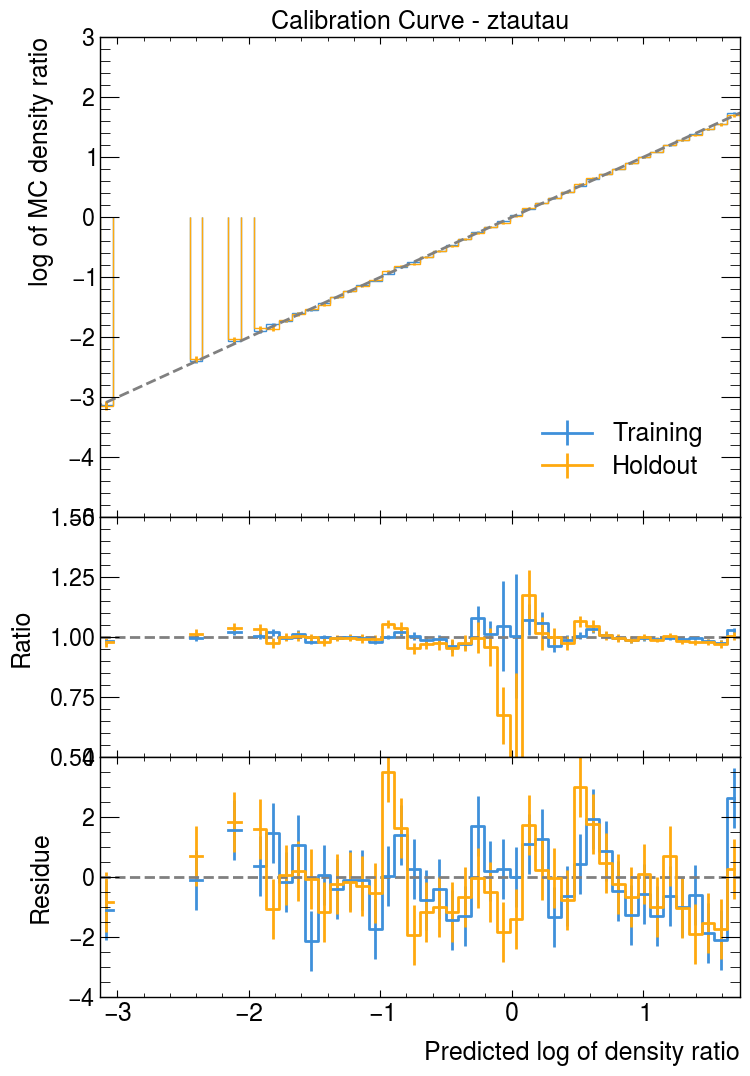

<Figure size 800x600 with 0 Axes>

In [28]:
num_bins_cal = 50

for process_type in mix_model_hypotheses:
    NN_training_mix_model[process_type].make_calib_plots(nbins=num_bins_cal, observable='llr')

- **Density ratio reweighting closure tests**
  
  Despite having a well-calibrated output and thus a robust probabilistic interpretation, the trained density ratios might not capture the full multi-dimensional event information $x$. In other words, the NNs might still be biased estimators of the optimal score function, as defined in the CARL paper (link).

  The next diagnostic involves verifying the following equality using 1D projections of $x$:

  $$\frac{p_c(x)}{p_{ref}(x)} \times p_{ref}(x) \sim p_c(x)$$

  We can do this one-by-one for all the observables used to model the density ratios, and also possibly the observables not used directly in the training but can still be well-estimated due to the NN learning the right physics.

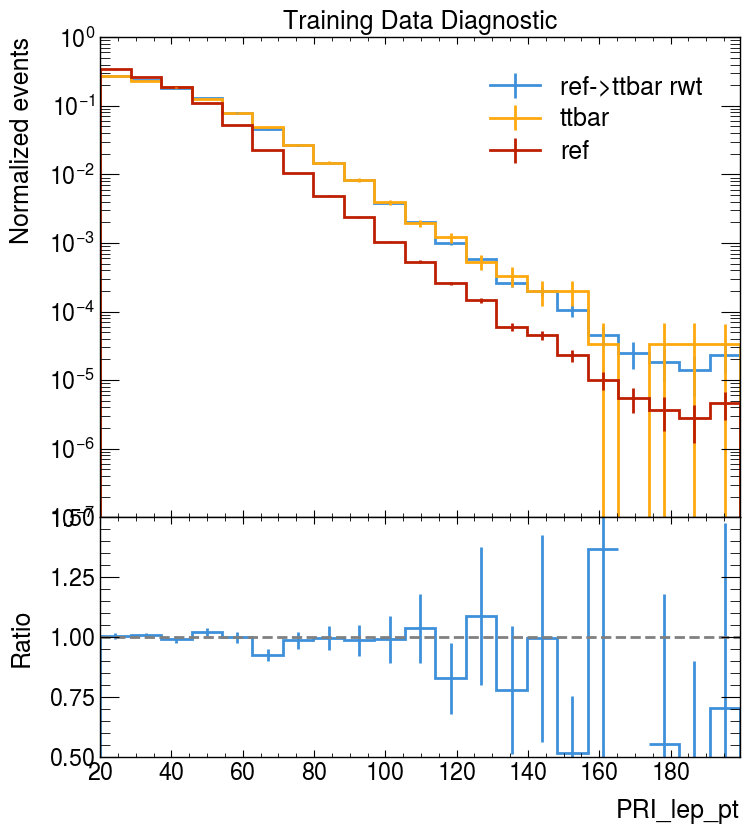

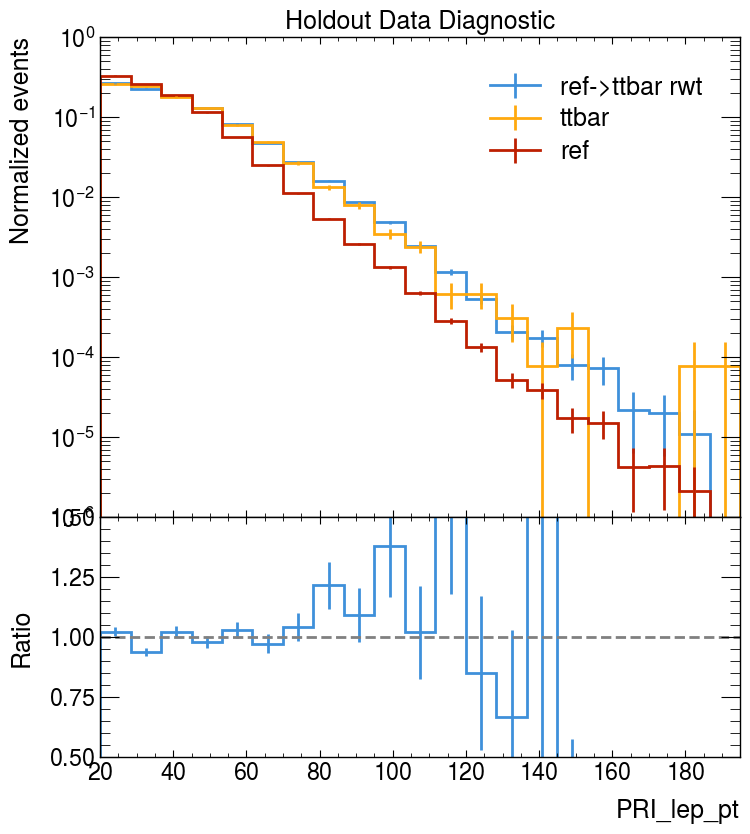

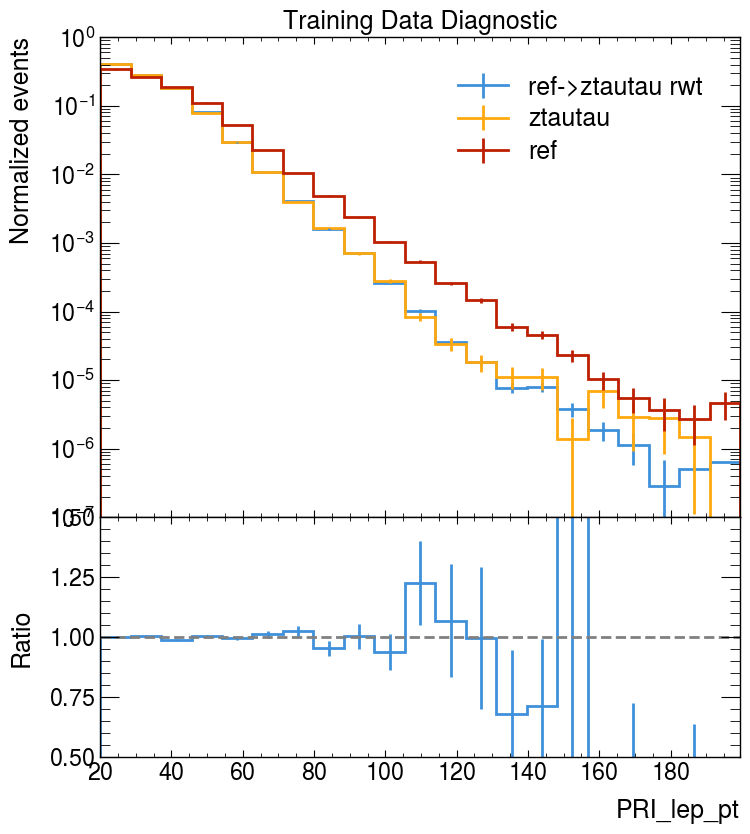

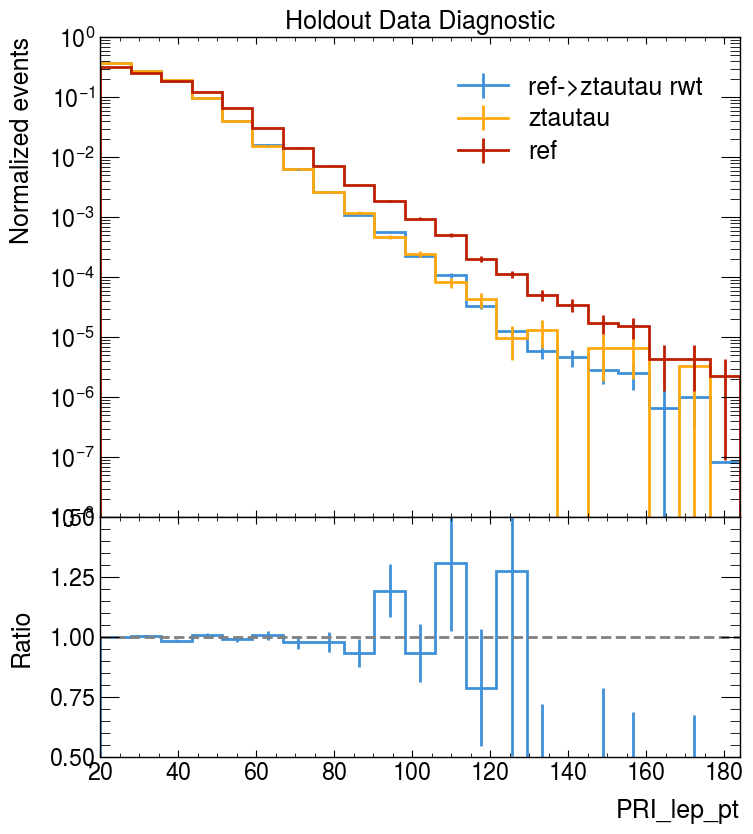

<Figure size 800x600 with 0 Axes>

In [29]:
variables_to_plot=['PRI_lep_pt'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

for process_type in mix_model_hypotheses:

    NN_training_mix_model[process_type].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [30]:
for process_type in mix_model_hypotheses:
    # Evaluate the density ratios p_c/p_ref for the full dataset and save for the inference step
    NN_training_mix_model[process_type].evaluate_and_save_ratios(dataset)

81211/81211 - 71s - 872us/step
81211/81211 - 88s - 1ms/step


Systematic Uncertainty Modelling
===

So far we have left out the nuisance parameter piece of the parameterized density ratio decomposition shown before:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)}$$

which will be estimated in the `Systematic_Uncertainty_Estimation.ipynb` notebook.

Training an Ensemble of NNs
===

In a realistic analysis, a large ensemble of NNs are trained to estimate density ratios, for *each* of the channels. **This reduces not only the variance but has also been found to reduce biases in the final fits.**

In the off-shell Higgs boson analysis, we used k-fold cross-validation, with k=10, to train an ensemble $N_{ens}\sim 250$ of NNs per density ratio $p_c(x)/p_{ref}(x)$. The density ratios used in the final fit are always evaluated on the holdout dataset and by using each of the folds as holdout once, the entire model for $p_c(x)/p_{ref}(x)$ consists of $N_{ens}\times k \sim 2500$ NNs. Each NN in the ensemble is trained by resampling data without replacement from the k-1 folds used for training.
